In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Modeling
Before proceeding to the generative models, my audio data will need to be converted to MIDI files for processing, which requires several steps for optimization.


In [ ]:
import os
import numpy as np
import librosa
import random

### Pitch Detection with CREPE
CREPE (Convolutional Representation for Pitch Estimation) is a deep learning model designed for pitch detection.

This will read each WAV file in my audio folder and uses CREPE to predict the pitch at each time step. The results are stored in pitch_data.

In [ ]:
!pip install crepe

In [ ]:
import crepe
from scipy.io import wavfile

audio_folder = '/content/gdrive/MyDrive/Violin_Comp_Data/converted_music_files_cleaned'
pitch_data = {}

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder, filename)
        sr, audio = wavfile.read(file_path)
        time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

        pitch_data[filename] = {
            'time': time,
            'frequency': frequency,
            'confidence': confidence
        }


### Rhythm and Tempo Analysis
This will detect note onsets and durations.

In [ ]:
import librosa

def analyze_rhythm(file_path):
    y, sr = librosa.load(file_path, sr=None)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=tempogram, sr=sr)
    return onset_times, tempo[0]


In [ ]:
audio_folder = '/content/gdrive/MyDrive/Violin_Comp_Data/converted_music_files_cleaned'
rhythm_data = {}

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder, filename)
        onset_times, tempo = analyze_rhythm(file_path)
        rhythm_data[filename] = {
            'onset_times': onset_times,
            'tempo': tempo
        }



### Align Pitch and Rhythm Data
This function aligns pitch data with rhythm data. Then, it iterates over the onset times and finds the closest time in the pitch data, then extracts the corresponding pitch. I'll use a confidence threshold to filter out uncertain pitch detections.

In [ ]:
def align_pitch_and_rhythm(pitch_data, rhythm_data):
    aligned_data = []
    for onset_time in rhythm_data['onset_times']:
        # Find the index of the closest time in pitch_data to the onset_time
        closest_index = np.argmin(np.abs(pitch_data['time'] - onset_time))
        pitch = pitch_data['frequency'][closest_index]
        confidence = pitch_data['confidence'][closest_index]

        # Only consider pitches with a confidence above a certain threshold
        if confidence > 0.8:
            aligned_data.append((onset_time, pitch))

    return aligned_data


### Create MIDI Files
With the aligned pitch and rhythm data, I will now create MIDI files. For simplicity, I will set each note's duration to the interval between its onset time and the next onset time.

In [ ]:
!pip install pretty_midi

In [ ]:
import pretty_midi

def create_midi(aligned_data, output_file='output.mid'):
    midi = pretty_midi.PrettyMIDI()
    violin = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Violin'))

    for i, (start_time, pitch) in enumerate(aligned_data):
        end_time = aligned_data[i+1][0] if i+1 < len(aligned_data) else start_time + 1
        note_number = pretty_midi.hz_to_note_number(pitch)

        # Ensure note_number is an integer and within MIDI range
        note_number = int(round(note_number))
        note_number = max(0, min(note_number, 127))

        note = pretty_midi.Note(
            velocity=100,
            pitch=note_number,
            start=start_time,
            end=end_time
        )
        violin.notes.append(note)

    midi.instruments.append(violin)
    midi.write(output_file)

# Directory to store all MIDI files
midi_folder = '/content/gdrive/MyDrive/Violin_Comp_Data/all_midi_files'

# Create the directory if it doesn't exist
if not os.path.exists(midi_folder):
    os.makedirs(midi_folder)


### Apply to All Files

In [ ]:
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        pitch_file = pitch_data[filename]
        rhythm_file = rhythm_data[filename]
        aligned_data = align_pitch_and_rhythm(pitch_file, rhythm_file)
        midi_file = f"{filename.split('.')[0]}.mid"
        create_midi(aligned_data, output_file=midi_file)


### Data Preparation
Defining a function for reading the MIDI files, which will give an array of notes and chords in the audio.

In [ ]:
from music21 import converter, instrument, note, chord

def read_midi(file):
    #print("Loading Music File:", file)
    notes = []

    # Parsing a MIDI file
    midi = converter.parse(file)

    # Grouping based on different instruments
    parts = instrument.partitionByInstrument(midi)

    # Check if there are parts, if not, consider the whole stream
    if parts:
        relevant_parts = parts.parts
    else:
        relevant_parts = [midi]

    # Looping over all parts to find violin
    for part in relevant_parts:
        if isinstance(part.getInstrument(), instrument.Violin) or "Violin" in part.partName:
            for element in part.recurse():
                # Note or chord handling
                if isinstance(element, note.Note):
                    notes.append((str(element.pitch), element.duration.quarterLength, element.offset))
                elif isinstance(element, chord.Chord):
                    notes.append(('.'.join(str(n) for n in element.normalOrder), element.duration.quarterLength, element.offset))

    return np.array(notes)


path = '/content/gdrive/MyDrive/Violin_Comp_Data/all_midi_files/'

# Read all the filenames
files = [i for i in os.listdir(path) if i.endswith(".mid")]

# Reading each MIDI file
notes_array = [read_midi(path + i) for i in files]


In [ ]:
print("Type of notes_array:", type(notes_array))
print("First two elements of notes_array:", notes_array[:2])


### Flatten Function and Notes Extraction
The following function is to flatten a nested list or array structure. After defining the function, I'll use it to flatten `notes_array` into a single list `notes_flat` for model processing.


In [ ]:
def flatten(array):
    for item in array:
        if isinstance(item, (list, np.ndarray)):
            yield from flatten(item)
        else:
            yield item

notes_flat = list(flatten(notes_array))


### Identifying Unique Notes

In [ ]:
unique_notes = list(set(notes_flat))
print("Number of unique notes:", len(unique_notes))


Number of unique notes: 524


### Top 20 Most Frequent Notes
Here, I'll count the frequency of each note using the `Counter` class and then plot a bar chart for the top 20 most frequent notes. This visualization helps in understanding the distribution of notes and identifying the most commonly occurring ones.


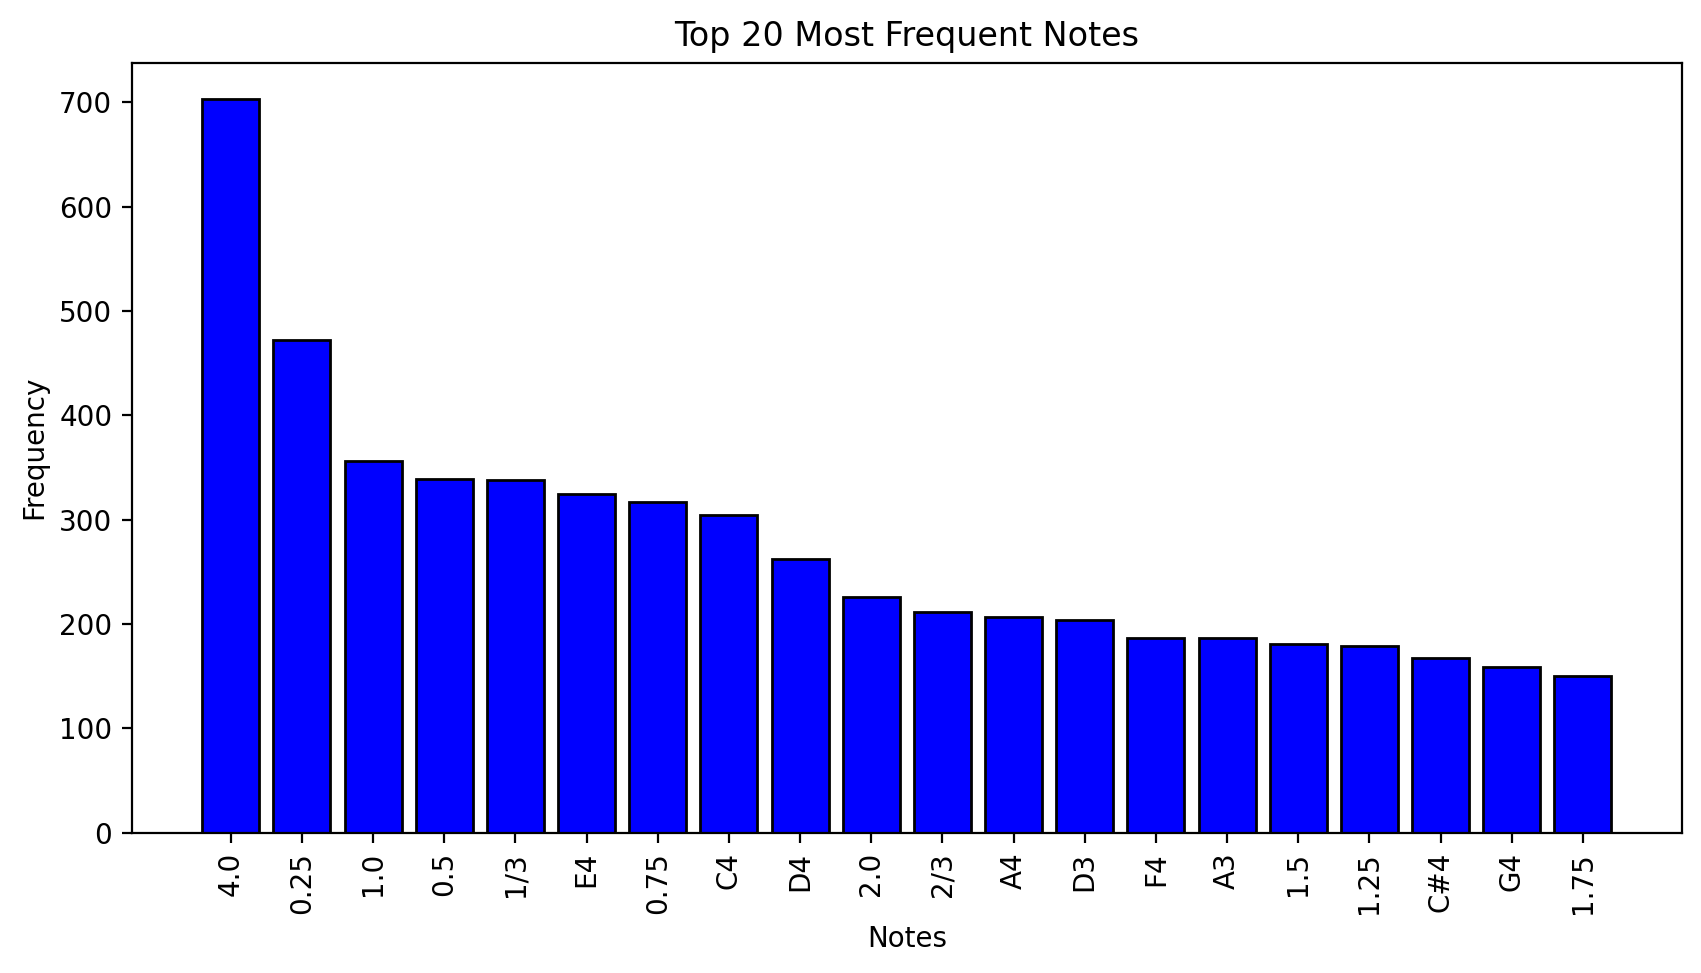

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each note
note_freq = Counter(notes_flat)

# Selecting top categories
top_n = 20
top_items = note_freq.most_common(top_n)
notes, frequencies = zip(*top_items)

# Use numerical indices as x-values
x_values = range(len(notes))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(x_values, frequencies, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Notes')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Frequent Notes')

# Set the x-axis labels to the note names
plt.xticks(x_values, notes, rotation=90)

# Show plot
plt.show()


### Note Frequency Histogram
Now I'll focuses on creating a histogram to visualize the frequency distribution of all notes. I'll compute the frequencies using the `Counter` class and plot a histogram, providing a visual representation of how note occurrences are distributed across the dataset.


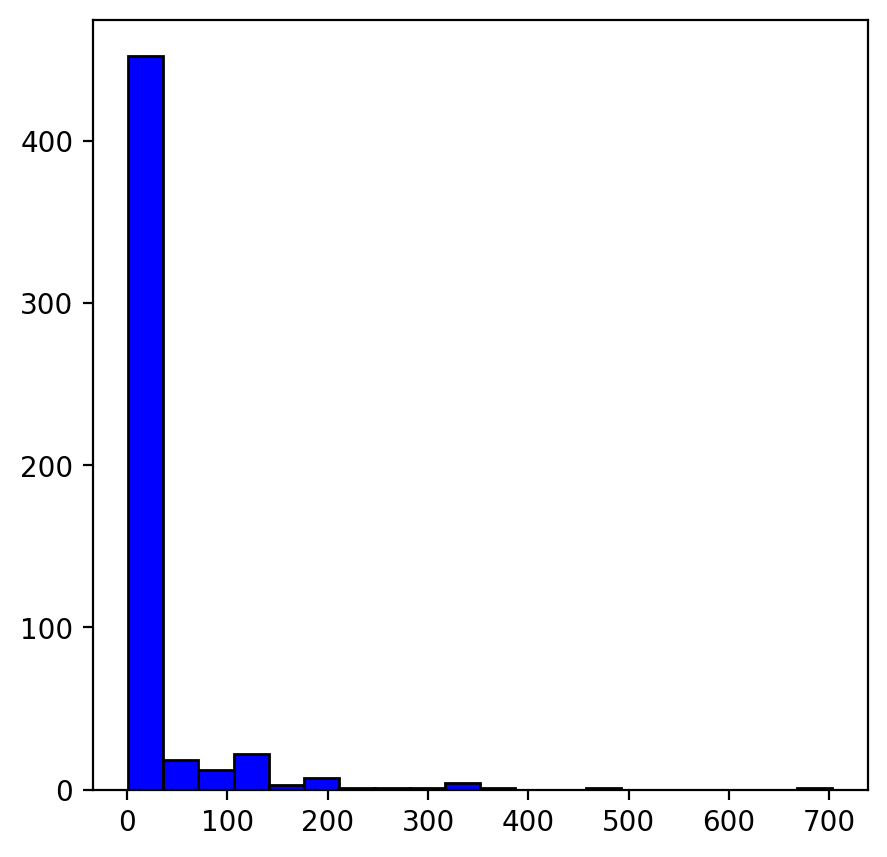

In [ ]:
# Computing frequency of each note
freq = dict(Counter(notes_flat))

# Consider only the frequencies
frequencies = [count for _, count in freq.items()]

# Set fig size
plt.figure(figsize=(5, 5))

# Plot
plt.hist(frequencies, bins=20, color='blue', edgecolor='black');


In [ ]:
frequent_notes = [note_flat for note_flat, count in freq.items() if count>=1]
print(len(frequent_notes))

524


### Creating a Filtered Music Dataset
Now, I'll iterate through `notes_array` to create a new dataset. This will filter and simplify the dataset based on the frequency of notes.


In [ ]:
new_music = []

for notes in notes_array:
    temp = []
    for note_flat in notes:
        for element in note_flat:
            if element in frequent_notes:
                temp.append(element)
                break
    new_music.append(temp)

new_music = np.array(new_music)


### Preparing Input and Output Sequences
Generating input and output sequences for the model. This sliding window approach prepares the dataset for time series forecasting or sequence prediction models. In this case, a sequence prediction model.


In [ ]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):

        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]

        x.append(input_)
        y.append(output)

x=np.array(x)
y=np.array(y)

### Mapping Notes to Integers for Inputs
For model training, I'll convert the notes in input and output sequences into integers. A unique integer is assigned to each note, creating a dictionary. Then, converting input sequences to integer sequences.

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_flat, number) for number, note_flat in enumerate(unique_x))


In [ ]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)

x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y))
y_seq=np.array([y_note_to_int[i] for i in y])

### Initiating Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=13)

### Building a Baseline WaveNet Model
Initializing the WaveNet model using Keras. The model includes an Embedding layer, several Convolutional layers with different dilation rates and Dropout layers for regularization, and Dense layers for the output. The model is compiled with the 'sparse_categorical_crossentropy' loss function and the 'adam' optimizer.

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()

#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True))

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

#model.add(Conv1D(256,5,activation='relu'))
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           6700      
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

### Setting Up Model Checkpointing
This will save the model whenever there is an improvement in the validation loss during training, ensuring that I always have the best performing model saved.

In [ ]:
mc=ModelCheckpoint('best_model3.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

### Training the Model
The model is trained with a batch size of 128 for 50 epochs. Validation data is used to monitor the model's performance on unseen data. The model checkpoint callback is used to save the best model during training.


In [ ]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 3.9667 - accuracy: 0.0735
Epoch 1: val_loss improved from inf to 3.93354, saving model to best_model3.h5
5/5 [==============================] - 2s 158ms/step - loss: 3.9667 - accuracy: 0.0735 - val_loss: 3.9335 - val_accuracy: 0.0446
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 3.8173 - accuracy: 0.0655
Epoch 2: val_loss improved from 3.93354 to 3.73498, saving model to best_model3.h5
5/5 [==============================] - 0s 95ms/step - loss: 3.8173 - accuracy: 0.0655 - val_loss: 3.7350 - val_accuracy: 0.0446
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 3.5660 - accuracy: 0.0671
Epoch 3: val_loss improved from 3.73498 to 3.49479, saving model to best_model3.h5
5/5 [==============================] - 0s 104ms/step - loss: 3.5660 - accuracy: 0.0671 - val_loss: 3.4948 - val_accuracy: 0.1083
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 3.3967 - accuracy: 0.1166
E

### Analysis of Model Training Performance (Loss and Accuracy)

#### Overview
The training of this model over 50 epochs shows a trend in both loss (a measure of error) and accuracy (a measure of correct predictions). This dual-metric evaluation provides a more comprehensive view of the model's performance.

#### Observations
- **Best Model Consideration**: The model saved at epoch 34 is likely the best model to use because it has the lowest validation loss.
  - Loss = 2.29707
  - Accuracy = .6438
- **Potential Overfitting**: Towards the end, the model shows signs of overfitting, as indicated by the plateauing and slight increases in validation loss, despite the training loss continuing to decrease.

#### Conclusion
The model has demonstrated a capacity to learn and improve both in terms of reducing error and increasing prediction accuracy. However, the fluctuations and final plateau in validation metrics suggest a need for further tuning or regularization to enhance model generalization.


### Loading the Best Model
This ensures that the version of the model that performed best on the validation data is used for predictions.


In [ ]:
from keras.models import load_model
model = load_model('best_model3.h5')

### Generating Music Predictions
This function generates a sequence of predicted notes using the trained model. Starting with a random sequence from the validation set, it predicts the next note iteratively. The function is used to create five separate sequences, which are then flattened into a single combined sequence for further processing.


In [ ]:
def generate_prediction(model, start_index, length=10, no_of_timesteps=32):
    random_music = x_val[start_index]

    predictions = []
    for i in range(length):
        random_music = random_music.reshape(1, no_of_timesteps)

        prob = model.predict(random_music)[0]
        y_pred = np.random.choice(range(len(prob)), p=prob)
        predictions.append(y_pred)

        random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
        random_music = random_music[1:]

    return predictions

# Generate 5 separate sequences
sequences = []
for _ in range(5):
    ind = np.random.randint(0, len(x_val) - 1)
    sequence = generate_prediction(model, ind)
    sequences.append(sequence)

# Flatten the list of lists into a single list
combined_sequence = [note for sequence in sequences for note in sequence]
print(combined_sequence)


### Converting Integers Back to Notes


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in combined_sequence]

### Converting Predictions to MIDI Format
This function takes the predicted notes and converts them into a MIDI format. It addresses both single notes and chords, assigning them to a violin instrument part. This allows the playback and evaluation of the generated music.


In [ ]:
from music21 import note, chord, instrument, stream, pitch

def convert_to_midi(prediction_output):
    offset = 0
    output_notes = []

    # Creating a violin part
    violin_part = stream.Part()
    violin_part.insert(0, instrument.Violin())

    for pattern in prediction_output:
        # Check if the pattern is an integer or a float (MIDI note number)
        if isinstance(pattern, (int, float)):
            try:
                # Convert float to int for MIDI note number
                pattern = int(pattern)
                new_note = note.Note(pattern)
                new_note.storedInstrument = instrument.Violin()
                new_note.offset = offset
                output_notes.append(new_note)
            except pitch.PitchException as e:
                print(f"Invalid MIDI note number: {pattern}, Error: {e}")
            offset += 0.5
            continue

        # Check if pattern is a string representing chords
        elif isinstance(pattern, str) and ('.' in pattern or pattern.isdigit()):
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                try:
                    new_note = note.Note(int(current_note))
                    new_note.storedInstrument = instrument.Violin()
                    notes.append(new_note)
                except pitch.PitchException as e:
                    print(f"Invalid note pattern in chord: {current_note}, Error: {e}")
                    continue

            if notes:
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                output_notes.append(new_chord)

        offset += 0.5

    # Add notes to the violin part
    for n in output_notes:
        violin_part.append(n)

    # Create a MIDI stream and write the file
    midi_stream = stream.Stream()
    midi_stream.append(violin_part)
    midi_stream.write('midi', fp='music.mid')

convert_to_midi(predicted_notes)


## Second Iteration of WaveNet Model Training

### Goals
- Address overfitting observed in the first model iteration.
- Improve model generalization on validation data.

### Updates
1. **Model Architecture**: Add regularization, modify layer configurations.
2. **Optimization**: Adjust learning rate, implement early stopping.
3. **Data Handling**: Enhance data augmentation, revise feature engineering.
4. **Training Approach**: Modifiy batch size and epoch strategy.
5. **Hyperparameter Tuning**: Conduct systematic hyperparameter optimization.

### Updated Model Architecture

In [ ]:
from keras.layers import Embedding, Conv1D, Dropout, MaxPool1D, GlobalMaxPool1D, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

# Clearing previous session!
K.clear_session()

model = Sequential()

# Embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))

# Convolutional Layer 1 - increased dropout
model.add(Conv1D(64, 3, padding='causal', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPool1D(2))

# Convolutional Layer 2 - consistent dropout to regularize
model.add(Conv1D(128, 3, activation='relu', dilation_rate=2, padding='causal'))
model.add(Dropout(0.3))
model.add(MaxPool1D(2))

# Convolutional Layer 3 - regularize
model.add(Conv1D(256, 3, activation='relu', dilation_rate=4, padding='causal'))
model.add(Dropout(0.3))
model.add(MaxPool1D(2))

# Global Max Pooling
model.add(GlobalMaxPool1D())

# Dense Layer - additional dropout layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           6700      
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

### Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model_updated.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

### Data Augmentation

In [ ]:
def augment_sequence(sequence, max_shift=3):
    # Shift the sequence by a small integer amount for augmentation
    shift = random.randint(-max_shift, max_shift)
    augmented_sequence = sequence + shift
    augmented_sequence = np.clip(augmented_sequence, 0, len(unique_x) - 1)
    return augmented_sequence

# Augmenting the training data
x_tr_augmented = [augment_sequence(seq) for seq in x_tr]
y_tr_augmented = y_tr[:]

# Convert augmented data to numpy arrays
x_tr_augmented = np.array(x_tr_augmented, dtype='int32')

x_val = np.array(x_val, dtype='int32')
y_val = np.array(y_val, dtype='int32')

### Training

In [ ]:
history = model.fit(x_tr_augmented, y_tr_augmented,
                    batch_size=128, # Adjusted batch size
                    epochs=100, # Incrased epochs
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 3.9630 - accuracy: 0.0575
Epoch 1: val_loss improved from inf to 3.94564, saving model to best_model_updated.h5
5/5 [==============================] - 4s 392ms/step - loss: 3.9630 - accuracy: 0.0575 - val_loss: 3.9456 - val_accuracy: 0.0318
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 3.8296 - accuracy: 0.0527
Epoch 2: val_loss improved from 3.94564 to 3.79354, saving model to best_model_updated.h5
5/5 [==============================] - 1s 151ms/step - loss: 3.8296 - accuracy: 0.0527 - val_loss: 3.7935 - val_accuracy: 0.0318
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 3.6398 - accuracy: 0.0703
Epoch 3: val_loss improved from 3.79354 to 3.63997, saving model to best_model_updated.h5
5/5 [==============================] - 1s 135ms/step - loss: 3.6398 - accuracy: 0.0703 - val_loss: 3.6400 - val_accuracy: 0.0573
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 3.5432 - accuracy: 0.0639
Epoch 4: val_loss did not improve from 3.63997
5/5 [==============================] - 0s 85ms/step - loss: 3.5432 - accuracy: 0.0639 - val_loss: 3.6836 - val_accuracy: 0.0828
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 3.5436 - accuracy: 0.0639
Epoch 5: val_loss did not i

### Analysis of Second Iteration Model

#### Overview
The model's training results over 42 epochs before early stopping.

#### Observations
**Moderate Learning:** The model showed moderate learning capability with some improvements in loss and accuracy, but not significant.
**Generalization Gap:** There is a noticeable gap between training and validation performance, suggesting issues with generalization.
- **Best Model Consideration**: The model saved at epoch 37 is likely the best model to use because it has the lowest validation loss.
  - Loss = 3.11492
  - Accuracy = .5032

### Conclusion
The model has shown some learning capability, but there is significant room for improvement, especially with generalization to validation data.

### Generating Predictions & Converting to MIDI

In [ ]:
model = load_model('best_model_updated.h5')

In [ ]:
def generate_prediction(model, start_index, length=10, no_of_timesteps=32):
    random_music = x_val[start_index]

    predictions = []
    for i in range(length):
        random_music = random_music.reshape(1, no_of_timesteps)

        prob = model.predict(random_music)[0]
        y_pred = np.random.choice(range(len(prob)), p=prob)
        predictions.append(y_pred)

        random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
        random_music = random_music[1:]

    return predictions

# Generate 5 separate sequences
sequences = []
for _ in range(5):
    ind = np.random.randint(0, len(x_val) - 1)
    sequence = generate_prediction(model, ind)
    sequences.append(sequence)

# Flatten the list of lists into a single list
combined_sequence_2 = [note for sequence in sequences for note in sequence]
#print(combined_sequence_2)


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes_2 = [x_int_to_note[i] for i in combined_sequence_2]

In [ ]:
def convert_to_midi(prediction_output):
    offset = 0
    output_notes = []

    # Creating a violin part
    violin_part = stream.Part()
    violin_part.insert(0, instrument.Violin())

    for pattern in prediction_output:
        # Check if the pattern is an integer or a float (MIDI note number)
        if isinstance(pattern, (int, float)):
            try:
                # Convert float to int for MIDI note number
                pattern = int(pattern)
                new_note = note.Note(pattern)
                new_note.storedInstrument = instrument.Violin()
                new_note.offset = offset
                output_notes.append(new_note)
            except pitch.PitchException as e:
                print(f"Invalid MIDI note number: {pattern}, Error: {e}")
            offset += 0.5
            continue

        # Check if pattern is a string representing chords
        elif isinstance(pattern, str) and ('.' in pattern or pattern.isdigit()):
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                try:
                    new_note = note.Note(int(current_note))
                    new_note.storedInstrument = instrument.Violin()
                    notes.append(new_note)
                except pitch.PitchException as e:
                    print(f"Invalid note pattern in chord: {current_note}, Error: {e}")
                    continue

            if notes:
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                output_notes.append(new_chord)

        offset += 0.5

    # Add notes to the violin part
    for n in output_notes:
        violin_part.append(n)

    # Create a MIDI stream and write the file
    midi_stream = stream.Stream()
    midi_stream.append(violin_part)
    midi_stream.write('midi', fp='music2.mid')

convert_to_midi(predicted_notes_2)


# Proceed to 'Model_2_LSTM.ipynb'
